In [1]:
import os
import numpy as np
import scipy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# base directory
example_segment = '../Example_1/' 
# b (date) segments
b_dates = [f'{example_segment}{_}' for _ in os.listdir(example_segment)]
# int splits 
int_splits = [b[0] for b in [os.listdir(a) for a in b_dates]]

# combo = [f'{a}/{b}' for ]
out = []
for date in b_dates:
    # combine b dates w/ int splits
    c = [f'{date}/{i_split}/processed_log/GNSS/live_gnss_qcom/value' for i_split in int_splits]
    out.append(c)
    
out

[['../Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/40/processed_log/GNSS/live_gnss_qcom/value',
  '../Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/50/processed_log/GNSS/live_gnss_qcom/value'],
 ['../Example_1/test_b0c9d2329ad1606b|2018-08-02--08-34-47/40/processed_log/GNSS/live_gnss_qcom/value',
  '../Example_1/test_b0c9d2329ad1606b|2018-08-02--08-34-47/50/processed_log/GNSS/live_gnss_qcom/value']]

In [3]:
import cupy

v0 = out[0]
v1 = out[1]

cupy.load(v0[0])

array([[ 3.77211070e+01, -1.22472312e+02,  7.42999983e+00,
         1.53322649e+12,  3.90000000e+01,  6.19999981e+00],
       [ 3.77213618e+01, -1.22472262e+02,  1.09600000e+01,
         1.53322649e+12,  3.80000000e+01,  7.19999981e+00],
       [ 3.77216432e+01, -1.22472240e+02,  1.44799995e+01,
         1.53322649e+12,  3.90000000e+01,  6.80000019e+00],
       [ 3.77219319e+01, -1.22472226e+02,  1.66200008e+01,
         1.53322650e+12,  3.40000000e+01,  6.19999981e+00],
       [ 3.77222951e+01, -1.22472221e+02,  2.00699997e+01,
         1.53322650e+12,  3.60000000e+01,  5.19999981e+00],
       [ 3.77226593e+01, -1.22472186e+02,  2.03600006e+01,
         1.53322650e+12,  3.70000000e+01,  6.40000010e+00],
       [ 3.77230520e+01, -1.22472166e+02,  2.04500008e+01,
         1.53322650e+12,  3.70000000e+01,  5.19999981e+00],
       [ 3.77233998e+01, -1.22472130e+02,  1.98299999e+01,
         1.53322650e+12,  3.80000000e+01,  5.59999990e+00],
       [ 3.77237253e+01, -1.22472126e+02,  1.912

In [4]:
import cudf

gdf0 = cudf.DataFrame()
gdf0['latitude'] = [float(val[0]) for val in cupy.load(v0[0])]
gdf0['longitude'] = [float(val[1]) for val in cupy.load(v0[0])]
gdf0 = cudf.concat([gdf0 for i in range(5**3)])

# gdf1 = cudf.DataFrame()
# gdf1['latitude'] = [float(val[0]*0.99) for val in cupy.load(v1[0])]
# gdf1['longitude'] = [float(val[1]*0.99) for val in cupy.load(v1[0])]
# gdf1 = cudf.concat([gdf1 for i in range(5**3)])

# gdf2 = cudf.DataFrame()
# gdf2['latitude'] = [float(val[0]*1.01) for val in cupy.load(v1[1])]
# gdf2['longitude'] = [float(val[1]*1.01) for val in cupy.load(v1[1])]
# gdf2 = cudf.concat([gdf1 for i in range(5**3)])

# gdf = cudf.concat([gdf0, gdf1, gdf2])
gdf = gdf0
gdf

latitude   longitude
0   37.721107 -122.472312
1   37.721362 -122.472262
2   37.721643 -122.472240
3   37.721932 -122.472226
4   37.722295 -122.472221
..        ...         ...
25  37.728900 -122.471886
26  37.729215 -122.471879
27  37.729543 -122.471849
28  37.729842 -122.471835
29  37.730144 -122.471823

[3750 rows x 2 columns]

## BlazingSQL

In [1]:
from blazingsql import BlazingContext
# connect to BlazingSQL
bc = BlazingContext(pool=False)

BlazingContext ready


In [2]:
import os
# identify path to data
path = f'{os.getcwd().split("/notebooks")[0]}/data/c2k19_live_gnss_qcom.csv'
path

'/home/winston@blazingdb.com/comma2k19/data/c2k19_live_gnss_qcom.csv'

In [4]:
%%time
bc.create_table('comma2k19', path, header=0)

CPU times: user 9.04 ms, sys: 406 µs, total: 9.45 ms
Wall time: 8.02 ms


In [10]:
%%time
# how's it look
bc.sql('SELECT * FROM comma2k19 LIMIT 3')

CPU times: user 20.5 ms, sys: 15.1 ms, total: 35.6 ms
Wall time: 23.4 ms


latitude   longitude      speed  utc_timestamp  altitude     bearing
0  37.594427 -122.417727  33.869999   1.532667e+12     101.0  141.899994
1  37.593950 -122.417255  33.650002   1.532667e+12     102.0  142.000000
2  37.593471 -122.416799  33.869999   1.532667e+12     106.0  141.899994

In [11]:
%%time
# tag pi & origin shift
pi = 3.141592653589793
o_shift = 2 * pi * 6378137 / 2

# convert lat & lng values to meters 
query = f'''
        SELECT 
            longitude * {o_shift} / 180 AS x, 
            LOG10(TAN(((90 + latitude) * {pi} / 360))) / {pi} / 180 * {o_shift} / 180 AS y,
            speed, utc_timestamp, altitude, bearing
        FROM 
            comma2k19
            '''

# how's the top look?
bc.sql(query).head(3)

CPU times: user 60.5 ms, sys: 1.06 ms, total: 61.6 ms
Wall time: 40.5 ms


x          y      speed  utc_timestamp  altitude     bearing
0 -1.362748e+07  60.617448  33.869999   1.532667e+12     101.0  141.899994
1 -1.362743e+07  60.616549  33.650002   1.532667e+12     102.0  142.000000
2 -1.362738e+07  60.615647  33.869999   1.532667e+12     106.0  141.899994

### Datashader

In [13]:
# datashader viz imports 
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf

CPU times: user 519 ms, sys: 14.6 ms, total: 533 ms
Wall time: 497 ms


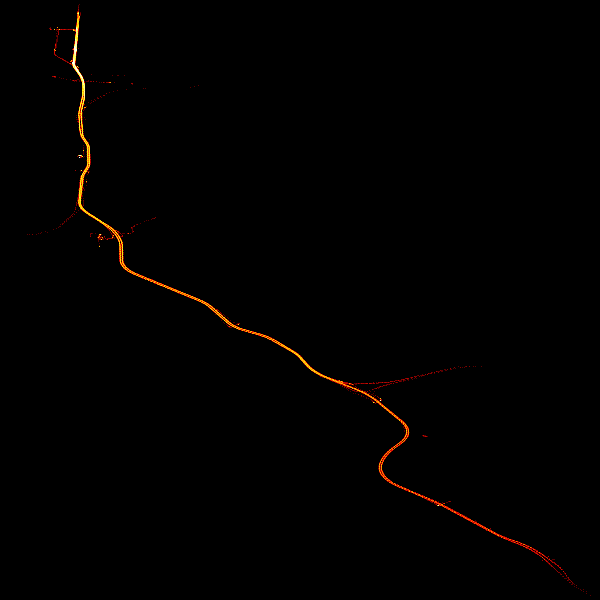

In [14]:
%%time
# execute query & lay out the canvas w/ dropoff locations 
agg = ds.Canvas().points(bc.sql(query).to_pandas(), 'x', 'y')

# shade in the picture w/ fire & display
tf.set_background(tf.shade(agg, cmap=fire), "black")

### Holoviews

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
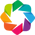

In [16]:
import holoviews as hv
from colorcet import fire
from holoviews import opts
from holoviews import extension, Points, Scatter, Path
import holoviews.operation.datashader as hd
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
# config holoviews
extension('bokeh')
pw = 450
ph = 450
opts.defaults(opts.Scatter(width=pw, height=ph, color='blue'), opts.RGB(width=pw, height=ph), opts.Curve(width=pw))

In [17]:
# set points plot
points = Points(bc.sql(query).to_pandas(), ['x', 'y'])

# set continuous path plot
paths = Path(bc.sql(query).to_pandas(), ['x', 'y'])

points + paths

:Layout
   .Points.I :Points   [x,y]   (speed,utc_timestamp,altitude,bearing)
   .Path.I   :Path   [x,y]   (speed,utc_timestamp,altitude,bearing)

In [18]:
# set datashader parameters & plot
comma_trips = datashade(points, x_sampling=1, y_sampling=1, cmap=fire, width=900, height=480)
# pull geo tiles
map_tiles = EsriImagery().opts(alpha=0.5, width=900, height=480, bgcolor='black')
# overlay geo tiles on comma trips
map_tiles * comma_trips

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [x,y]   (R,G,B,A)

# REGULAR NOTEBOOK BELOW

In [3]:
# all the files present for every minute of driving
os.listdir(example_segment)

['preview.png', 'raw_log.bz2', 'video.hevc', 'processed_log', 'global_pose']

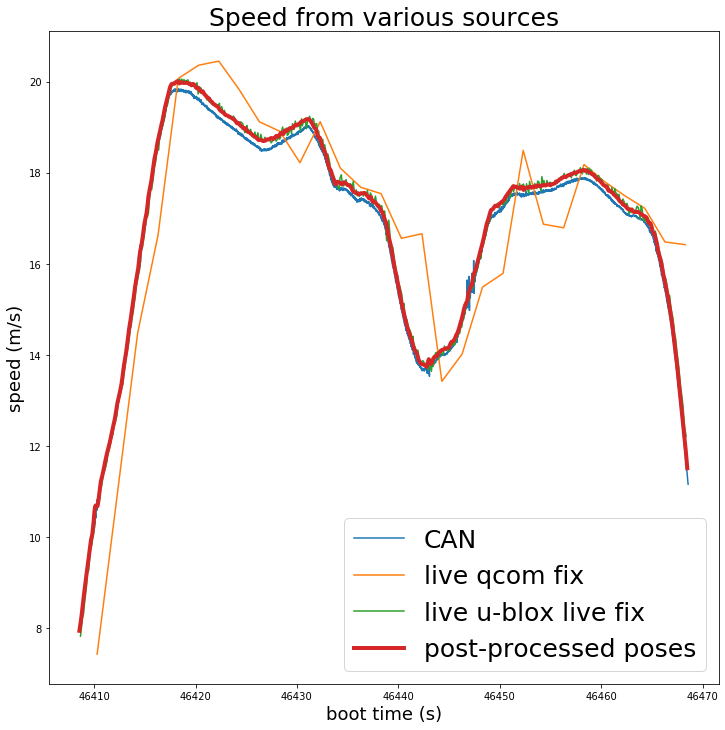

In [4]:
# We can plot the speed from a variety of sources
figsize(12,12);

# from can data
plot(np.load(example_segment + 'processed_log/CAN/speed/t'),
     np.load(example_segment + 'processed_log/CAN/speed/value'),
     label='CAN');

# from qcom gnss data
plot(np.load(example_segment + 'processed_log/GNSS/live_gnss_qcom/t'),
     np.load(example_segment + 'processed_log/GNSS/live_gnss_qcom/value')[:,2],
     label='live qcom fix');

# from u-blox gnss data
plot(np.load(example_segment + 'processed_log/GNSS/live_gnss_ublox/t'),
     np.load(example_segment + 'processed_log/GNSS/live_gnss_ublox/value')[:,2],
     label='live u-blox live fix');

# from post-processed data
plot(np.load(example_segment + 'global_pose/frame_times'),
     np.linalg.norm(np.load(example_segment + 'global_pose/frame_velocities'),axis=1), linewidth=4,
     label='post-processed poses');

title('Speed from various sources', fontsize=25);
legend(fontsize=25);
xlabel('boot time (s)', fontsize=18);
ylabel('speed (m/s)', fontsize=18);

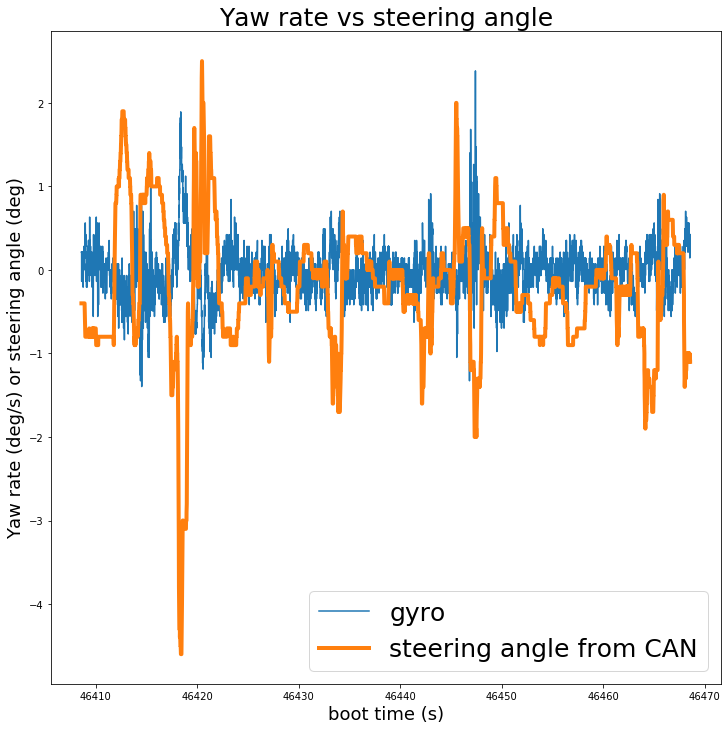

In [5]:
# We can plot the yaw rate and compare it to the steering angle
# This segment doesn't have much turning, if it did we would see
# very clear negative correlation, now we only see it at about
# 12s into the segment.
figsize(12,12);


# yaw rate from gyro
plot(np.load(example_segment + 'processed_log/IMU/gyro/t'),
     (180/pi)*np.load(example_segment + 'processed_log/IMU/gyro/value')[:,2],
     label='gyro');

# from can data we
plot(np.load(example_segment + 'processed_log/CAN/steering_angle/t'),
     np.load(example_segment + 'processed_log/CAN/steering_angle/value'), linewidth=4,
     label='steering angle from CAN')


title('Yaw rate vs steering angle', fontsize=25);
legend(fontsize=25);
xlabel('boot time (s)', fontsize=18);
ylabel('Yaw rate (deg/s) or steering angle (deg)', fontsize=18);

In [6]:
import lib.coordinates as coord

In [7]:
import lib.orientation as orient

In [8]:
example_segment

'../Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/40/'

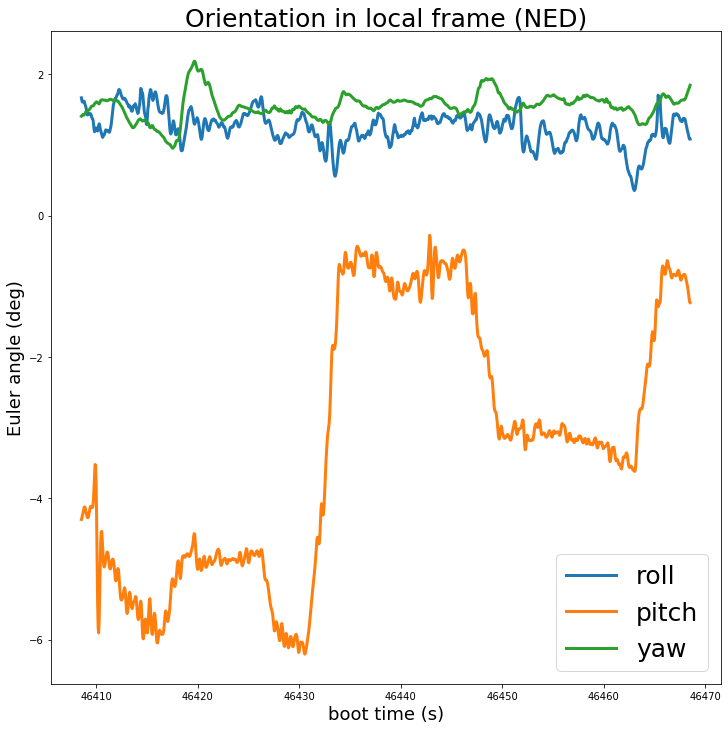

In [9]:
# we can plot the orientation of the camera in 
# euler angles respective to the local ground plane,
# i.e. the North East Down reference frame. This is more
# intuitive than the quaternion.

frame_times = np.load(example_segment + 'global_pose/frame_times')
frame_positions = np.load(example_segment + 'global_pose/frame_positions')
frame_orientations = np.load(example_segment + 'global_pose/frame_orientations')
euler_angles_ned_deg = (180/pi)*orient.ned_euler_from_ecef(frame_positions[0], orient.euler_from_quat(frame_orientations))


plot(frame_times, euler_angles_ned_deg[:,0], label='roll', linewidth=3);
plot(frame_times, euler_angles_ned_deg[:,1], label='pitch', linewidth=3);
plot(frame_times, euler_angles_ned_deg[:,2], label='yaw', linewidth=3);
title('Orientation in local frame (NED)', fontsize=25);
legend(fontsize=25);
xlabel('boot time (s)', fontsize=18);
ylabel('Euler angle (deg)', fontsize=18);

In [10]:
# We can project the path driven onto the first image

# first we convert the frame_positions to the frame
# defined by the pose of the first frame
ecef_from_local = orient.rot_from_quat(frame_orientations[0])
local_from_ecef = ecef_from_local.T
frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_positions - frame_positions[0])

In [11]:
from lib.camera import img_from_device, denormalize, view_frame_from_device_frame

In [12]:
def draw_path(device_path, img, width=1, height=1.2, fill_color=(128,0,255), line_color=(0,255,0)):
  device_path_l = device_path + np.array([0, 0, height])                                                                    
  device_path_r = device_path + np.array([0, 0, height])                                                                    
  device_path_l[:,1] -= width                                                                                               
  device_path_r[:,1] += width

  img_points_norm_l = img_from_device(device_path_l)
  img_points_norm_r = img_from_device(device_path_r)
  img_pts_l = denormalize(img_points_norm_l)
  img_pts_r = denormalize(img_points_norm_r)

  # filter out things rejected along the way
  valid = np.logical_and(np.isfinite(img_pts_l).all(axis=1), np.isfinite(img_pts_r).all(axis=1))
  img_pts_l = img_pts_l[valid].astype(int)
  img_pts_r = img_pts_r[valid].astype(int)

  for i in range(1, len(img_pts_l)):
    u1,v1,u2,v2 = np.append(img_pts_l[i-1], img_pts_r[i-1])
    u3,v3,u4,v4 = np.append(img_pts_l[i], img_pts_r[i])
    pts = np.array([[u1,v1],[u2,v2],[u4,v4],[u3,v3]], np.int32).reshape((-1,1,2))
    cv2.fillPoly(img,[pts],fill_color)
    cv2.polylines(img,[pts],True,line_color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


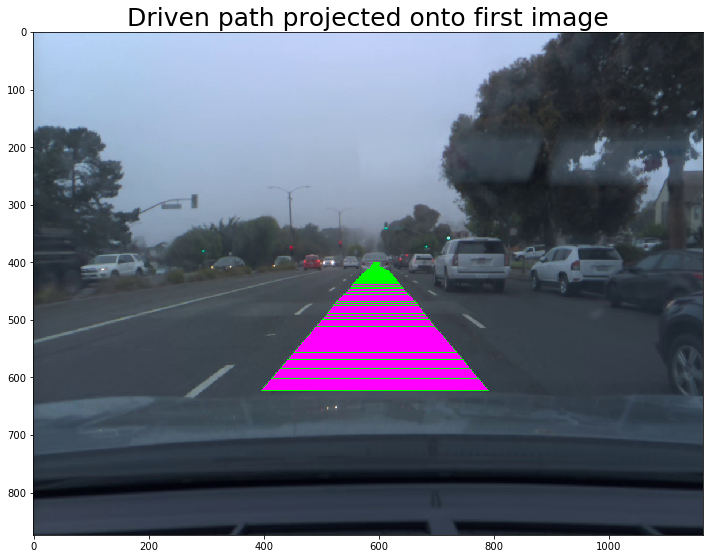

In [13]:
import cv2
img = imread(example_segment + 'preview.png')
draw_path(frame_positions_local[11:250], img)
figsize(12,12);
imshow(img);
title('Driven path projected onto first image', fontsize=25);

In [18]:
from blazingsql import BlazingContext
# connect to BlazingSQL
bc = BlazingContext(pool=False)

BlazingContext ready


In [19]:
# import os
# # determine wildcard file path to coordinate values
# data_path = f'{os.getcwd().split("notebooks/")[0]}/data/b0*2018*/*/processed_log/GNSS/live_gnss_qcom/value'
# # how's it look?
# data_path

In [23]:
import os
# determine wildcard file path to coordinate values
data_path = f'{os.getcwd().split("notebooks/")[0]}/Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47'
data_path = f'{data_path}/*/processed_log/GNSS/live_gnss_qcom/value'
# how's it look?
data_path
bc.create_table('test', data_path, file_type='.csv')

ParseSchemaError: [ParseSchema Error] Path '/home/winston@blazingdb.com/comma2k19/notebooks/Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/*/processed_log/GNSS/live_gnss_qcom/value' does not exist. File or directory paths are expected to be in one of the following formats: For local file paths: '/folder0/folder1/fileName.extension'    For local file paths with wildcard: '/folder0/folder1/*fileName*.*'    For local directory paths: '/folder0/folder1/'    For s3 file paths: 's3://registeredFileSystemName/folder0/folder1/fileName.extension'    For s3 file paths with wildcard: '/folder0/folder1/*fileName*.*'    For s3 directory paths: 's3://registeredFileSystemName/folder0/folder1/'    For gs file paths: 'gs://registeredFileSystemName/folder0/folder1/fileName.extension'    For gs file paths with wildcard: '/folder0/folder1/*fileName*.*'    For gs directory paths: 'gs://registeredFileSystemName/folder0/folder1/'    For HDFS file paths: 'hdfs://registeredFileSystemName/folder0/folder1/fileName.extension'    For HDFS file paths with wildcard: '/folder0/folder1/*fileName*.*'    For HDFS directory paths: 'hdfs://registeredFileSystemName/folder0/folder1/'

Exception ignored in: 'cio.parseSchemaPython'
cio.ParseSchemaError: [ParseSchema Error] Path '/home/winston@blazingdb.com/comma2k19/notebooks/Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/*/processed_log/GNSS/live_gnss_qcom/value' does not exist. File or directory paths are expected to be in one of the following formats: For local file paths: '/folder0/folder1/fileName.extension'    For local file paths with wildcard: '/folder0/folder1/*fileName*.*'    For local directory paths: '/folder0/folder1/'    For s3 file paths: 's3://registeredFileSystemName/folder0/folder1/fileName.extension'    For s3 file paths with wildcard: '/folder0/folder1/*fileName*.*'    For s3 directory paths: 's3://registeredFileSystemName/folder0/folder1/'    For gs file paths: 'gs://registeredFileSystemName/folder0/folder1/fileName.extension'    For gs file paths with wildcard: '/folder0/folder1/*fileName*.*'    For gs directory paths: 'gs://registeredFileSystemName/folder0/folder1/'    For HDFS file paths: 'hdf

In [25]:
import cupy
arr = cupy.load('../Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/40/processed_log/GNSS/live_gnss_qcom/value')

In [26]:
len(arr)

30

In [27]:
for _ in arr:
    print(len(_))

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


In [28]:
for _ in arr:
    print(_[0])

37.72110698
37.72136179
37.72164325
37.72193187
37.72229511
37.72265934
37.72305199
37.72339978
37.72372532
37.72405189
37.72435812
37.72470609
37.72501937
37.72534447
37.72566721
37.72597186
37.72627494
37.7264889
37.72670482
37.72697624
37.72725943
37.72763023
37.72789395
37.72821309
37.7285809
37.7289003
37.72921468
37.7295428
37.72984227
37.7301439
